<a href="https://colab.research.google.com/github/leemijung/Deep_Learning/blob/main/ex05_transferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. settings

### 1) Important required libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
#import utils
!pip install utils

### 2) Hyperparameter

In [2]:
batch_size=16
learning_rate=0.0001
epoch=20

n_node=1024
dropratio=0.5

imgsize=256

## 2. Data Loader

### 트레이닝 데이터

In [6]:
img_dir="animal/train"
train_data=dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(imgsize*2),
    transforms.RandomCrop(imgsize),
    transforms.RandomHorizontalFlip(),
    
    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))
print(train_data.__len__())

train_batch=data.DataLoader(train_data, batch_size=batch_size,
                           shuffle=True, num_workers=2)

46


In [7]:
img_dir="animal/val"
dev_data=dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))
dev_batch=data.DataLoader(dev_data, batch_size=batch_size,
                           shuffle=True, num_workers=2)

img_dir="animal/test"
test_data=dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))
test_batch=data.DataLoader(test_data, batch_size=batch_size,
                           shuffle=True, num_workers=2)

nclass=len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d"
     %(train_data.__len__(), dev_data.__len__(), test_data.__len__()))

# of classes: 2
['Lion', 'Tiger']
{'Lion': 0, 'Tiger': 1}
46
Training: 46, Dev: 14, Test: 10


In [14]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['Lion', 'Tiger']
['Lion', 'Tiger']
['Lion', 'Tiger']


## 3. Model

### 1) pretrained VGG Model

In [15]:
vgg=models.vgg19(pretrained=True)

for name, module in vgg.named_children():
    print(name)
    
print(list(vgg.children())[0])
print(list(vgg.children())[-1])


features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

### 2) Customized Fully Model

In [27]:
base_dim=64
fsize=int(imgsize/32)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        self.layer0=nn.Sequential(*list(vgg.children())[0])
        
        self.layer1=nn.Sequential(
            nn.Linear(8*base_dim*fsize*fsize, int(n_node)),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
        
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
        
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
        
            nn.Linear(n_node, nclass),
        )
        
        for m in self.layer1.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)  
    def forward(self, x):
        out=self.layer0(x)
        out=out.view(out.size(0), -1)
        out=self.layer1(out)
        return out


### 3) Model on GPU

In [28]:
model=MyVGG().cuda()
for params in model.layer0.parameters():
    params.required_grad=False
    
for params in model.layer1.parameters():
    params.required_grad=True
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [29]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## 4. Optimizer & Loss

In [30]:
loss_func=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.layer1.parameters(), lr=learning_rate)

## 5. Train

In [31]:
import utils

total_time=0
disp_step=10

to_train=True
if(to_train==False):
    netname='./nets/TigerLion_vgg19_10.pkl'
    model=torch.load(netname)
else:
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval()
    train_corr=utils.ComputeCorr(train_batch, model)
    dev_corr=utils.ComputeCorr(dev_batch, model)
    test_corr=utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f"
         %(train_corr, dev_corr, test_corr))
    model.train()
    
    netname='./nets/TigerLion_vgg19'
    
    x_epoch=[]
    y_train_err=[]
    y_dev_err=[]
    y_test_err=[]
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
    # 학습 재시작인 경우
#    netname='../nets/media_pre_vgg19/pkl'
#    model=torch.load(netname)
    # 파라미터 학습 여부 결정
#    for params in model.layer0.parameters():
#        params.required_grad=False
#    for params in model.layer1.parameters():
#        params.required_grad=True
#    for i in range(34, epoch):

    for i in range(epoch):
        start_time=time.time()
        print("%d.." %i),
        for img, label in train_batch:
            img=Variable(img).cuda()
            label=Variable(label).cuda()
            
            optimizer.zero_grad()
            output=model(img)
            loss=loss_func(output, label)
            loss.backward()
            optimizer.step()
            
        end_time=time.time()
        duration=end_time-start_time
        total_time+=duration
        if(i%disp_step==0)or(i==epoch-1):
            torch.save(model, netname+'_%d.pkl'%i, )
            print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),
            
            model.eval()
            
            train_corr=utils.ComputeCorr(train_batch, model)
            dev_corr=utils.ComputeCorr(dev_batch, model)
            test_corr=utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f, "
                 %(train_corr, dev_corr, test_corr)),
            model.train()
            print("time: %.2f sec.." %(total_time))
            
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec.." %total_time)
    


3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 56.52, dev: 35.71, test: 20.00
0..

[0/20] loss: 1.107, 
Correct of train: 71.74, dev: 85.71, test: 100.00, 
time: 1.07 sec..
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/20] loss: 0.314, 
Correct of train: 100.00, dev: 100.00, test: 100.00, 
time: 12.65 sec..
11..
12..
13..
14..
15..
16..
17..
18..
19..

[19/20] loss: 0.152, 
Correct of train: 97.83, dev: 100.00, test: 100.00, 
time: 23.10 sec..
Total time: 23.10 sec..


## 6. Evaluation for dev & test data

Normalized confusion matrix


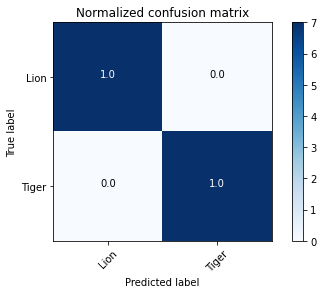

Confusion matrix, without normalization


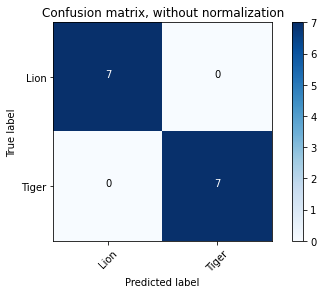

	 acc  |	 pre  |	 rec  |	 f1
 Lion: 1.00 |	 1.00 |	 1.00 |	 1.00
 Tiger: 1.00 |	 1.00 |	 1.00 |	 1.00
*accuracy: 1.00, precision: 1.00, recall: 1.00, *f1 score: 1.00
[AP]
Lion: 1.00
Tiger: 1.00

[mAP] 1.000
[miAP] 1.000


In [32]:
model.eval()
_, _, _=utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Category: Lion
 True predicted images/total Lion category: 7 / 7
Predicted probability:
[0.94219357 0.05780642]


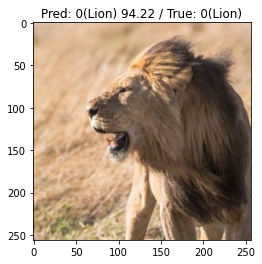

Predicted probability:
[9.999861e-01 1.391600e-05]


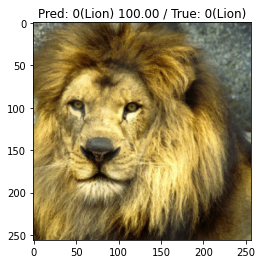

Predicted probability:
[0.9986987  0.00130126]


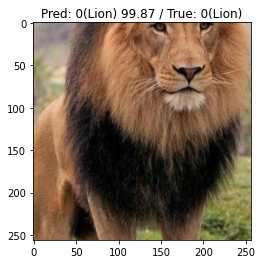

 False predicted images/total Lion category: 0 / 7
Category: Tiger
 True predicted images/total Tiger category: 7 / 7
Predicted probability:
[0.04857866 0.9514213 ]


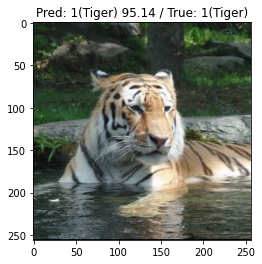

Predicted probability:
[0.10181051 0.8981895 ]


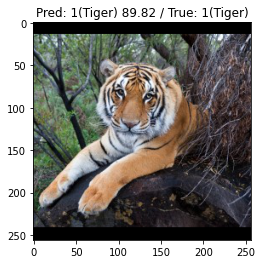

Predicted probability:
[0.00943631 0.9905637 ]


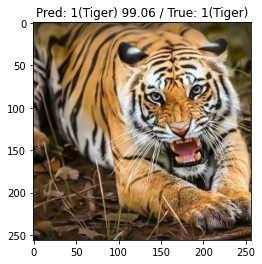

 False predicted images/total Tiger category: 0 / 7


In [33]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=3)